## VAE Hawkes Process Estimation - Tutorial

In [150]:
import os

import numpy as np
import pandas as pd
import scienceplots

import matplotlib.pyplot as plt

from dl.mlp_model import MLPTrainer
from dl.vae_model import VAETrainer
import variables.prep_var as prep

from evaluation.eval import compute_errors, compute_nrmse
from hawkes.simulation import hawkes_simulations, MLE
from hawkes.discretisation import discretise
from hawkes.hyperparameters import hyper_params_simulation
from tools.utils import read_parquet, timer
from visualization.error_viz import convergence_rate, errors_boxplots, effects_boxplots
from preprocessing.dataset import split_data, create_datasets, create_data_loaders

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preprocessing

In [151]:
# Training/Validation/Testing dataset generation

# Intensity Decay Parameter (β) = U(p = 1, q = 3)
# Branching Ratio (η) = U(a = 0.05, b = 0.8)
# Expected Activity (E) = 500
# Time Horizon (T) = 100
# Interval Length (∆) = 1
# Number of processes = 100_000

# Hawkes process hyper-parameters generation
params, alpha, beta, eta, mu = hyper_params_simulation(filename="vae/hawkes_hyperparams.parquet")

# Hawkes processes simulations
simulated_events_seqs = hawkes_simulations(alpha, beta, mu, filename="vae/hawkes_simulations.parquet")

# Discrétiser les processus de Hawkes
discret_simulated_events_seqs = discretise(simulated_events_seqs, filename="vae/binned_hawkes_simulations.parquet")

### Training

In [74]:
# Data Preparation (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

x = read_parquet("vae/binned_hawkes_simulations.parquet")
# y = read_parquet("vae/hawkes_hyperparams.parquet")

train_x, train_y, val_x, val_y, test_x, test_y = split_data(x, x) 
train_dataset, val_dataset, test_dataset = create_datasets(train_x, train_y, val_x, val_y, test_x, test_y)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)

In [3]:
# Trained models

# model, train_losses, val_losses, val_y_pred, val_eta, val_mu = MLPTrainer().train_model(train_loader, val_loader, val_x, val_y)
model, train_losses, val_losses, val_x_pred = VAETrainer().train_model(train_loader, val_loader, val_x, val_y)
%load_ext tensorboard

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
PoissonVAE                               [10000, 100]              [10000, 100]              --                             --                   --                        --                        True
├─Sequential: 1-1                        [10000, 100]              [10000, 37]               --                             --                   --                        --                        True
│    └─Linear: 2-1                       [10000, 100]              [10000, 75]               7,575                      33.56%                   --                        75,750,000                True
│    └─ReLU: 2-2                         [10000, 75]               [10000, 75]               --                             --                   --                        --              

Epoch 10000/10000 - train_loss: -298.7943, val_loss: -315.1854, annealing: 1.0000: 100%|██████████| 10000/10000 [19:08:03<00:00,  6.89s/it] 
c:\Users\Nicolas Girard\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\jit\_trace.py:1084: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%epsilon : Float(5000, 15, strides=[15, 1], requires_grad=0, device=cpu) = aten::randn_like(%std, %65, %66, %67, %68, %69) # c:\Users\Nicolas Girard\Documents\VAE_HAWKES_PROCESS_ESTIMATION\src\dl\vae_model.py:76:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _check_trace(
c:\Users\Nicolas Girard\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\jit\_trace.py:1084: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 499951 / 500000 (100

Best model loading (2023_06_23_01_00_19_MICSHPEG8GIRARD_best_model.pt)...


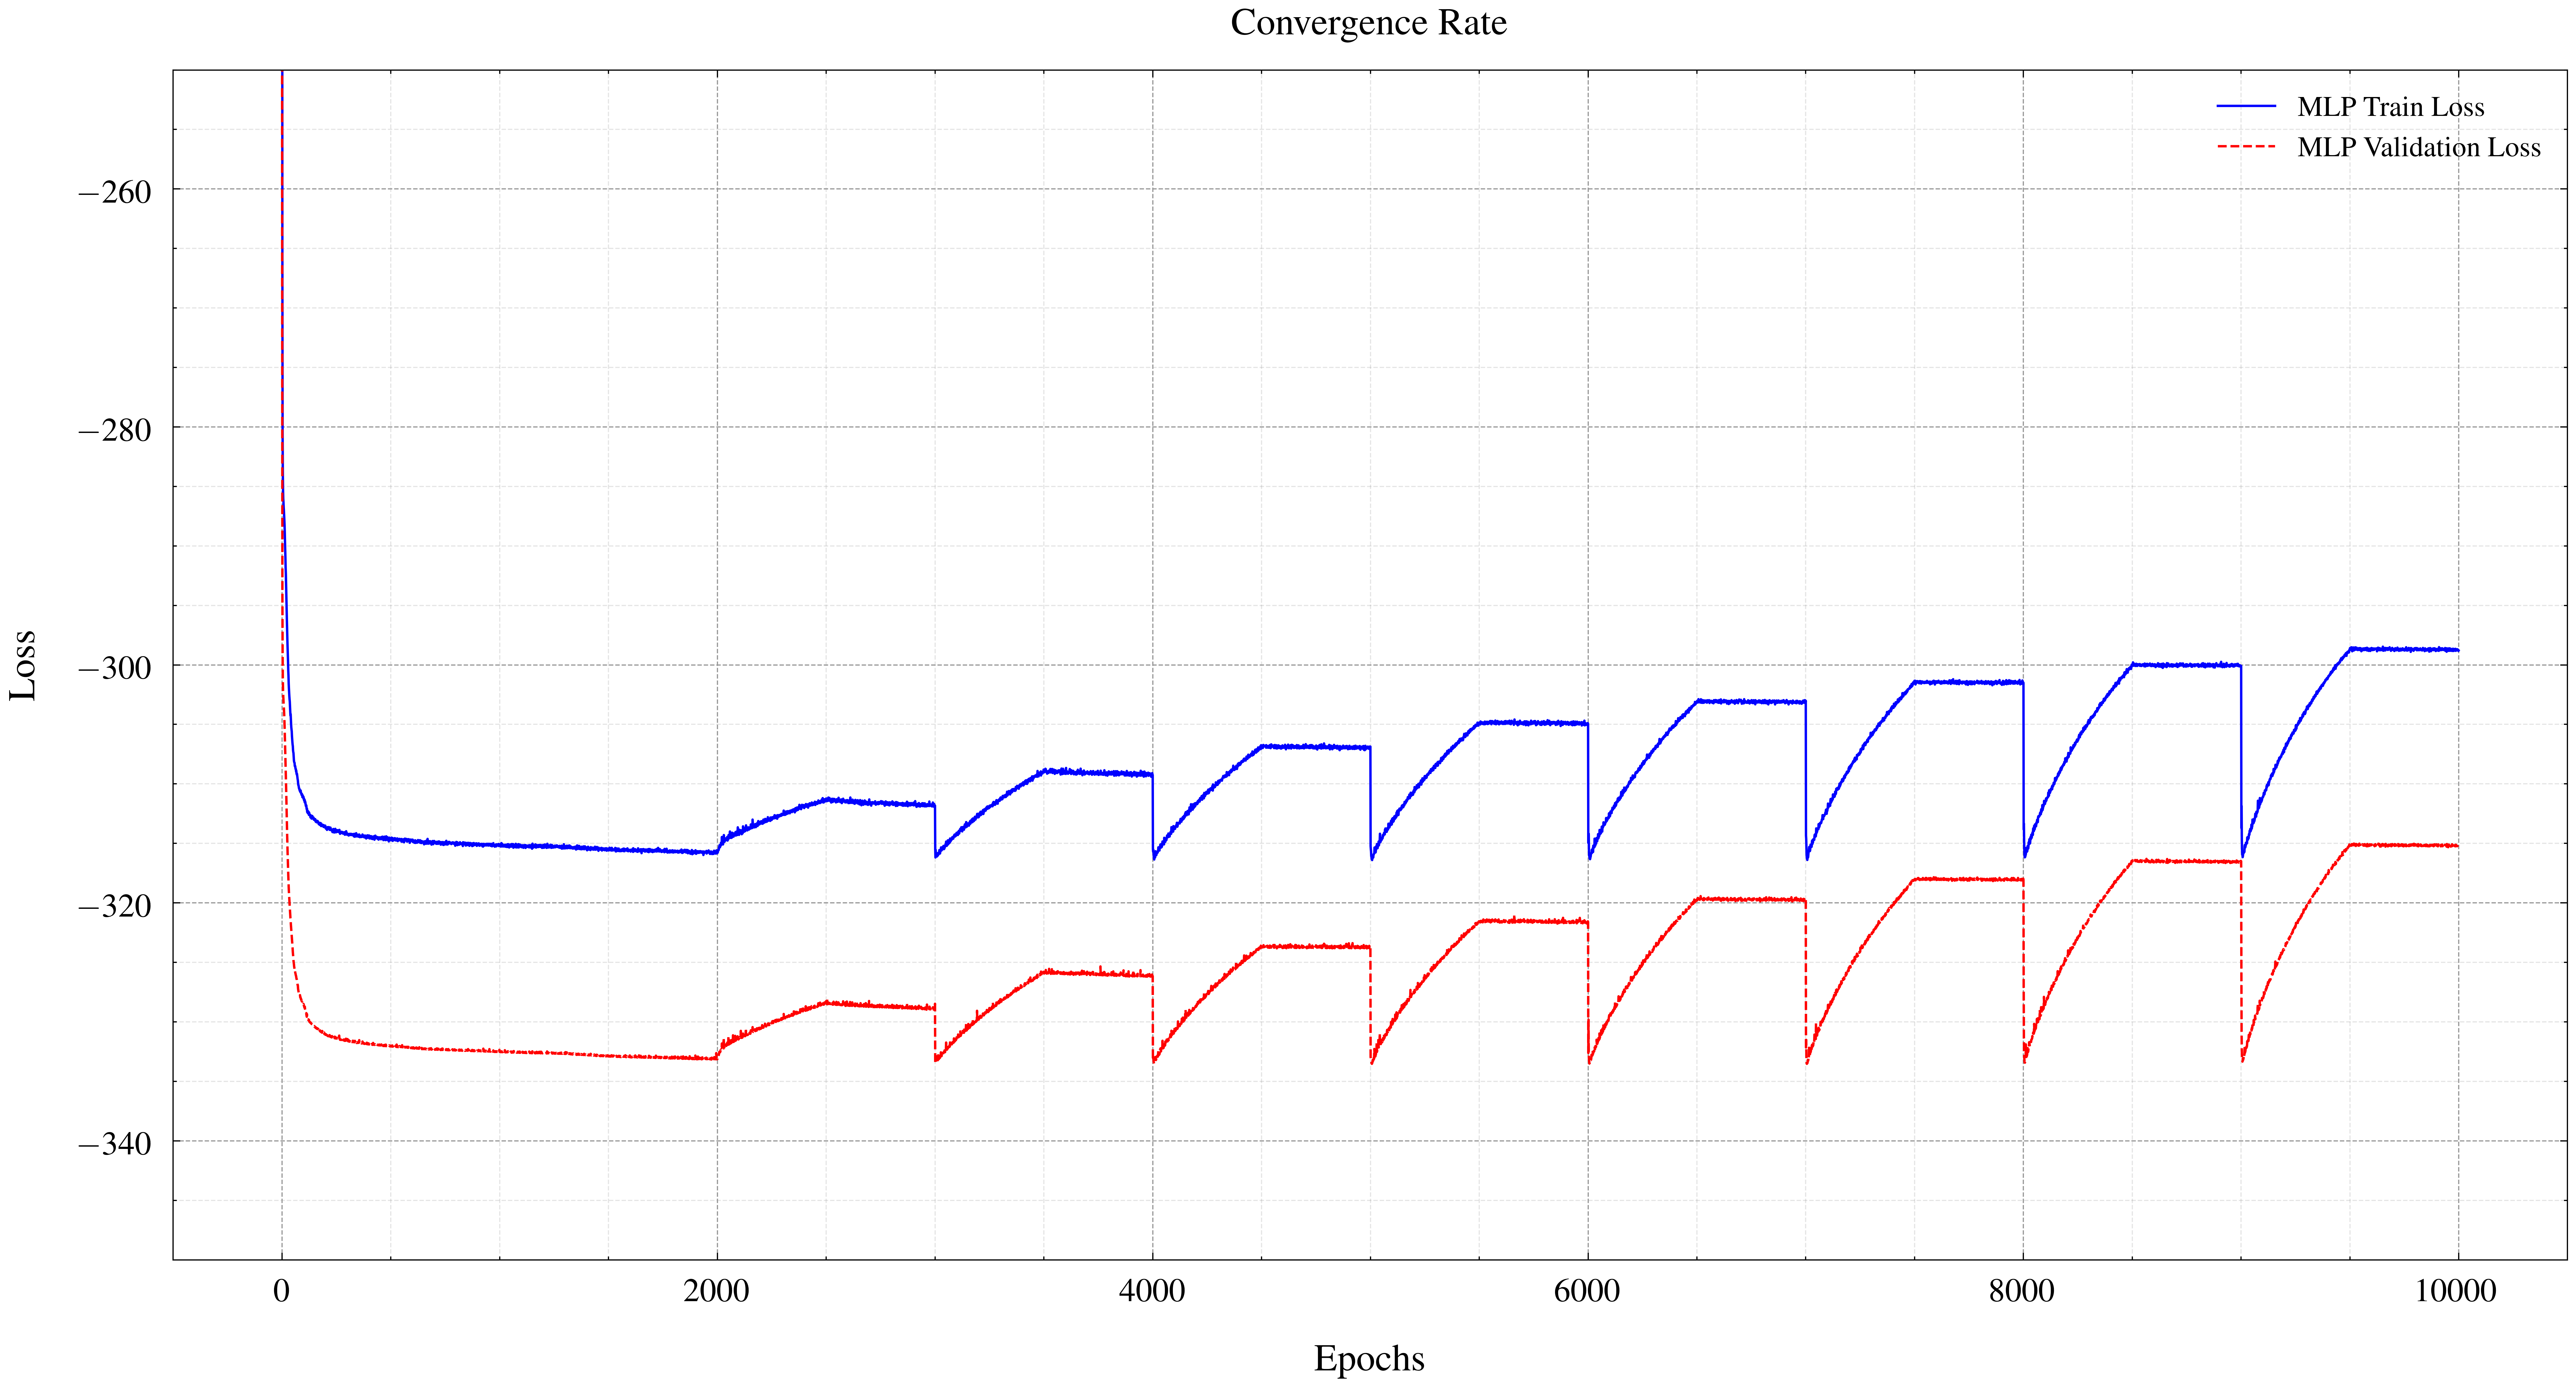

In [27]:
# Convergence rate plots

# bench_losses = read_parquet('benchmark/losses_benchmark.parquet')
# mlp_losses = read_parquet('br_mlp/losses_mlp_br_0.05_0.8.parquet')
vae_losses = read_parquet('vae/losses_vae.parquet')

convergence_rate(losses=[vae_losses], models=["MLP"], colors=["blue", "red"])

### Testing

In [154]:
# Tested models (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

# x = read_parquet("br_mlp/binned_hawkes_simulations_br_0.05_0.8.parquet")
# y = read_parquet("br_mlp/hawkes_hyperparams_br_0.05_0.8.parquet")

# test_x, test_y, _, _, _, _ = split_data(x, y[['eta', 'mu']])
# test_y_pred, _, _ = MLPTrainer().test_model(test_x, test_y)

x = read_parquet("vae/binned_hawkes_simulations_beta_1_eta_0.2.parquet")
# x = read_parquet("vae/binned_hawkes_simulations_beta_3_eta_0.2.parquet")
# x = read_parquet("vae/binned_hawkes_simulations_beta_1_eta_0.7.parquet")
# x = read_parquet("vae/binned_hawkes_simulations_beta_3_eta_0.7.parquet")

test_x, test_y, _, _, _, _ = split_data(x, x) 
intensity_pred = VAETrainer().test_model(test_x, test_y)

%load_ext tensorboard

Best model loading (2023_06_26_16_16_46_MICSHPEG8GIRARD_best_model.pt)...
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Evaluation

In [157]:
beta_1_br_02_pred = read_parquet('vae/predictions_beta_1_eta_0.2.parquet')
# beta_3_br_02_pred = read_parquet('vae/predictions_beta_3_eta_0.2.parquet')
# beta_1_br_07_pred = read_parquet('vae/predictions_beta_1_eta_0.7.parquet')
# beta_3_br_07_pred = read_parquet('vae/predictions_beta_3_eta_0.7.parquet')

results = compute_nrmse(alpha, beta, mu, simulated_events_seqs, beta_1_br_02_pred['intensities'])
results

AttributeError: 'list' object has no attribute 'to_numpy'

In [578]:
# Computed NRMSE error + reconstruction plots

# beta_1_br_02_pred = read_parquet('vae/predictions_beta_1_eta_0.2.parquet')
# beta_3_br_02_pred = read_parquet('vae/predictions_beta_3_eta_0.2.parquet')
# beta_1_br_07_pred = read_parquet('vae/predictions_beta_1_eta_0.7.parquet')
# beta_3_br_07_pred = read_parquet('vae/predictions_beta_3_eta_0.7.parquet')

delta_025_errors = compute_nrmse(delta_025_pred[['eta_true', 'mu_true']], delta_025_pred[['eta_pred', 'mu_pred']], model_name="MLE_DELTA_0.25", filename="deltas_mle/errors_mle_delta_0.25.parquet")

# effects_boxplots(errors=[delta_025_errors[["eta_error", "mu_error"]], delta_05_errors[["eta_error", "mu_error"]], delta_1_errors[["eta_error", "mu_error"]], delta_2_errors[["eta_error", "mu_error"]], delta_5_errors[["eta_error", "mu_error"]]],
#                  errors_rel=[delta_025_errors[["eta_rel_error", "mu_rel_error"]], delta_05_errors[["eta_rel_error", "mu_rel_error"]], delta_1_errors[["eta_rel_error", "mu_rel_error"]], delta_2_errors[["eta_rel_error", "mu_rel_error"]], delta_5_errors[["eta_rel_error", "mu_rel_error"]]],
#                  label_names = ["MLE"])

shape: (1, 5)
┌────────────────┬───────────────────┬───────────────────┬─────────────┬─────────┐
│ Model          ┆ Error Average (η) ┆ Error Average (μ) ┆ MRE (η)     ┆ MRE (μ) │
│ ---            ┆ ---               ┆ ---               ┆ ---         ┆ ---     │
│ str            ┆ f32               ┆ f32               ┆ f32         ┆ f32     │
╞════════════════╪═══════════════════╪═══════════════════╪═════════════╪═════════╡
│ MLE_DELTA_0.25 ┆ 562.958496        ┆ 0.4355            ┆ 2045.394775 ┆ 0.163   │
└────────────────┴───────────────────┴───────────────────┴─────────────┴─────────┘
shape: (1, 5)
┌───────────────┬───────────────────┬───────────────────┬─────────────┬─────────┐
│ Model         ┆ Error Average (η) ┆ Error Average (μ) ┆ MRE (η)     ┆ MRE (μ) │
│ ---           ┆ ---               ┆ ---               ┆ ---         ┆ ---     │
│ str           ┆ f32               ┆ f32               ┆ f32         ┆ f32     │
╞═══════════════╪═══════════════════╪═══════════════════╪══════